<a href="https://colab.research.google.com/github/TurkuNLP/textual-data-analysis-course/blob/main/sequence_labeling_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence labeling example

Let's train a transformer model on a Named Entity Recognition (NER) dataset.

---

## Setup

Install the required Python packages:

In [1]:
!pip install --quiet transformers datasets evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.1 MB/s eta 0:00:00


Import the libraries we'll be using here.

In [2]:
import datasets
import transformers
import evaluate

from pprint import pprint

Make things a bit more quiet. (This only affects what shows on screen when running. If you're debugging, you probably want to comment these out.)

In [3]:
transformers.utils.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()
datasets.disable_progress_bar()

---

## Load dataset

Load a dataset for training using `datasets`.

In [4]:
DATASET = 'conll2003'

builder = datasets.load_dataset_builder(DATASET)
dataset = datasets.load_dataset(DATASET)

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


Let's have a look at the description and dataset.

In [5]:
print(builder.info.description)

The shared task of CoNLL-2003 concerns language-independent named entity recognition. We will concentrate on
four types of named entities: persons, locations, organizations and names of miscellaneous entities that do
not belong to the previous three groups.

The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on
a separate line and there is an empty line after each sentence. The first item on each line is a word, the second
a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags
and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only
if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag
B-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. Note the dataset uses IOB2
tagging scheme, whereas the original dataset uses IOB1.

For 

In [6]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


We have the conventional split into `train`, `validation`, and `test`.

We're here only interested in the `tokens` and `ner_tags`. (In particular, the `ner_tags` and `chunk_tags` are included to support methods based on manually engineered features, and as such not highly relevant to the deep learning approach we're pursuing here.)

Let's have a look at one example.

In [7]:
print(dataset['train'][0]['tokens'])
print(dataset['train'][0]['ner_tags'])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[3, 0, 7, 0, 0, 0, 7, 0, 0]


Take note of the number of different labels and create mappings from label IDs to label strings and vice versa; we'll need these later.

In [8]:
label_names = dataset['train'].features['ner_tags'].feature.names
print('Labels:', label_names)

num_labels = len(label_names)
id2label = { k: v for k, v in enumerate(label_names) }
label2id = { v: k for k, v in enumerate(label_names) }

print('Number of labels:', num_labels)
print('id2label mapping:', id2label)
print('labelid2 mapping:', label2id)

Labels: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
Number of labels: 9
id2label mapping: {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}
labelid2 mapping: {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


Let's see that example again, applying the label mapping:

In [9]:
for token, tag_id in zip(dataset['train'][0]['tokens'], dataset['train'][0]['ner_tags']):
    print(f'{token}\t{id2label[tag_id]}')

EU	B-ORG
rejects	O
German	B-MISC
call	O
to	O
boycott	O
British	B-MISC
lamb	O
.	O


---

## Tokenize and vectorize dataset

As in the [text classification notebook](https://github.com/TurkuNLP/textual-data-analysis-course/blob/main/text_classification_basic_example.ipynb), we'll first load the tokenizer that corresponds to the model that we want to use. `AutoTokenizer` is a convenience class that will return the appropriate tokenizer for the model it's given as an argument:

In [10]:
MODEL = 'bert-base-cased'

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)

The tokenizer will, most importantly, produce `input_ids`, which identify the tokens of the text.

The BERT tokenizer also produces an `attention_mask`, which can be used to make the model ignore some tokens, and `token_type_ids`, which can differentiate parts of the input e.g. when it consists of two separate texts.

In [11]:
pprint(tokenizer('this is an example sentence'))

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101, 1142, 1110, 1126, 1859, 5650, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


A key point here is to note that the data already has its own definition of "token", and the tokenizer may split some of those into parts:

In [12]:
input_ids = tokenizer('Turku is not in the vocabulary').input_ids


print(input_ids)
print()
print(tokenizer.convert_ids_to_tokens(input_ids))

[101, 17037, 4661, 1358, 1110, 1136, 1107, 1103, 18074, 102]

['[CLS]', 'Tu', '##rk', '##u', 'is', 'not', 'in', 'the', 'vocabulary', '[SEP]']


For each sentence, our data consists of a tokenized list of strings ("words") rather than a single string. If we call the tokenizer with its default options, it interprets each token as a different example:

In [13]:
print(dataset['train'][0]['tokens'])
print()

for ids in tokenizer(dataset['train'][0]['tokens']).input_ids:
    print(tokenizer.convert_ids_to_tokens(ids))

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

['[CLS]', 'EU', '[SEP]']
['[CLS]', 'rejects', '[SEP]']
['[CLS]', 'German', '[SEP]']
['[CLS]', 'call', '[SEP]']
['[CLS]', 'to', '[SEP]']
['[CLS]', 'boycott', '[SEP]']
['[CLS]', 'British', '[SEP]']
['[CLS]', 'la', '##mb', '[SEP]']
['[CLS]', '.', '[SEP]']


To get the correct mapping, we provide `is_split_into_words=True` to the tokenizer.

In [14]:
tokens = 'Turku is not in the vocabulary'.split()
tokenized = tokenizer(tokens, is_split_into_words=True)

print(tokens)
print()
pprint(tokenizer.convert_ids_to_tokens(tokenized.input_ids))

['Turku', 'is', 'not', 'in', 'the', 'vocabulary']

['[CLS]', 'Tu', '##rk', '##u', 'is', 'not', 'in', 'the', 'vocabulary', '[SEP]']


The tokenizer also provides us with a mapping from the tokenizer tokens to "original" tokens ("words")

In [15]:
tokenized.word_ids()

[None, 0, 0, 0, 1, 2, 3, 4, 5, None]

With `is_split_into_words=True`, we can tokenize the input so that its tokens are compatible with the model, but the labels will be misaligned.

In [16]:
from itertools import zip_longest

token_ids = tokenizer(dataset['train'][0]['tokens'], is_split_into_words=True).input_ids
tag_ids = dataset['train'][0]['ner_tags']

for token_id, tag_id in zip_longest(token_ids, tag_ids):
    token = tokenizer.convert_ids_to_tokens(token_id)
    tag = id2label[tag_id] if tag_id is not None else None
    print(f'{token}\t{tag}')

[CLS]	B-ORG
EU	O
rejects	B-MISC
German	O
call	O
to	O
boycott	B-MISC
British	O
la	O
##mb	None
.	None
[SEP]	None


To resolve this, we'll borrow a function from [a transformers tutorial](https://huggingface.co/course/chapter7/2). Here, `-100` is a "magic value" for a label that pytorch ignores.

In [17]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:    # Start of a new word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:          # Special token            
            new_labels.append(-100)
        else:                          # Same word as previous token
            label = labels[word_id]
            if label % 2 == 1:         # If label is B-XXX we change it to I-XXX
                label += 1
            new_labels.append(label)
    return new_labels

We'll also borrow a function for jointly tokenizing the text and aliging labels:

In [18]:
def tokenize_and_align_labels(inputs):
    outputs = tokenizer(inputs['tokens'], truncation=True, is_split_into_words=True)
    new_labels = []
    for i, labels in enumerate(inputs['ner_tags']):
        word_ids = outputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    outputs['labels'] = new_labels
    return outputs

We'll then apply this to the whole dataset:

In [19]:
dataset = dataset.map(tokenize_and_align_labels, batched=True)

Now these should match up:

In [20]:
token_ids = dataset['train'][0]['input_ids']
tag_ids = dataset['train'][0]['labels']

for token_id, tag_id in zip_longest(token_ids, tag_ids):
    token = tokenizer.convert_ids_to_tokens(token_id)
    tag = id2label[tag_id] if tag_id != -100 else None
    print(f'{token}\t{tag}')

[CLS]	None
EU	B-ORG
rejects	O
German	B-MISC
call	O
to	O
boycott	O
British	B-MISC
la	O
##mb	O
.	O
[SEP]	None


---

## Instantiate model

Now, we'll instantiate a pretrained model with a sequence labeling head. In the `transformers` library, this class of models are named `...ModelForTokenClassification`. (cf. `...ModelForSequenceClassification`) We'll again use the `Auto` variant to get the appropriate class based on model name.

**NOTE**: we need to provide the number of labels to `from_pretrained` so that the function knows the size of the output layer that is required. The `id2label` and `label2id` mappings allow the model to report its classification results in interpretable text labels.

In [21]:
model = transformers.AutoModelForTokenClassification.from_pretrained(
    MODEL,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

---

## Training configuration

To assess the progress and results of training, we'll use the standard `seqeval` library. We'll also need to introduce a function that takes model outputs and the labels from the dataset and calls the metric.

Here, we'll again borrow from [the transformers tutorial](https://huggingface.co/course/chapter7/2):

In [22]:
metrics = evaluate.load('seqeval')


def compute_metrics(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[i] for i in label if i != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metrics.compute(predictions=true_predictions, references=true_labels)
    return {
        'precision': all_metrics['overall_precision'],
        'recall': all_metrics['overall_recall'],
        'f1': all_metrics['overall_f1'],
        'accuracy': all_metrics['overall_accuracy'],
    }

We'll also need a collator for padding the examples to the same length to process them in batches.

In [23]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

The `TrainingArguments` class configures many of the details of the model training. You may want to try optimizing the following hyperparameters to improve model performance:

* `learning_rate`: the step size for weight updates
* `per_device_train_batch_size`: number of examples per training batch
* `max_steps`: the maximum number of steps to train for

In [24]:
trainer_args = transformers.TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='steps',
    logging_strategy='steps',
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    max_steps=1500,
)

Finally, we'll create a custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) to store values logged during training so that we can more easily examine them later. (This is only needed for visualization and is not necessary to understand in detail.)

In [25]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

---

## Train (fine-tune) model

In [26]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[training_logs], 
)

max_steps is given, it will override any value given in num_train_epochs


In [27]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14041
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1500
  Number of trainable parameters = 107726601
You're using a BertTokenizerFast tokenizer. Please note that with a f

{'loss': 0.5813, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.11}
{'eval_loss': 0.20818530023097992, 'eval_precision': 0.6521936459909229, 'eval_recall': 0.7255132951868057, 'eval_f1': 0.686902485659656, 'eval_accuracy': 0.9418820274327427, 'eval_runtime': 11.1213, 'eval_samples_per_second': 292.233, 'eval_steps_per_second': 9.172, 'epoch': 0.11}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.1814, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.23}
{'eval_loss': 0.1341094821691513, 'eval_precision': 0.7676088617265088, 'eval_recall': 0.845506563446651, 'eval_f1': 0.804676863938496, 'eval_accuracy': 0.9614852534290929, 'eval_runtime': 10.9045, 'eval_samples_per_second': 298.042, 'eval_steps_per_second': 9.354, 'epoch': 0.23}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.1328, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.34}
{'eval_loss': 0.10609908401966095, 'eval_precision': 0.8333598093725179, 'eval_recall': 0.8828677213059576, 'eval_f1': 0.8573996894663726, 'eval_accuracy': 0.9700506269500206, 'eval_runtime': 11.2684, 'eval_samples_per_second': 288.418, 'eval_steps_per_second': 9.052, 'epoch': 0.34}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.101, 'learning_rate': 1.4666666666666666e-05, 'epoch': 0.46}
{'eval_loss': 0.09893299639225006, 'eval_precision': 0.8679580306698951, 'eval_recall': 0.9049141703130259, 'eval_f1': 0.8860509186784213, 'eval_accuracy': 0.9730529228233354, 'eval_runtime': 11.2179, 'eval_samples_per_second': 289.716, 'eval_steps_per_second': 9.093, 'epoch': 0.46}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.0934, 'learning_rate': 1.3333333333333333e-05, 'epoch': 0.57}


Saving model checkpoint to checkpoints/checkpoint-500
Configuration saved in checkpoints/checkpoint-500/config.json


{'eval_loss': 0.08059851825237274, 'eval_precision': 0.8759501859938541, 'eval_recall': 0.9114776169639852, 'eval_f1': 0.893360824742268, 'eval_accuracy': 0.9767322069818096, 'eval_runtime': 11.192, 'eval_samples_per_second': 290.386, 'eval_steps_per_second': 9.114, 'epoch': 0.57}


Model weights saved in checkpoints/checkpoint-500/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-500/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.0906, 'learning_rate': 1.2e-05, 'epoch': 0.68}
{'eval_loss': 0.07207226008176804, 'eval_precision': 0.8954590003266907, 'eval_recall': 0.9225849882194548, 'eval_f1': 0.9088196286472149, 'eval_accuracy': 0.979234120209572, 'eval_runtime': 11.4729, 'eval_samples_per_second': 283.276, 'eval_steps_per_second': 8.891, 'epoch': 0.68}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.088, 'learning_rate': 1.0666666666666667e-05, 'epoch': 0.8}
{'eval_loss': 0.07879689335823059, 'eval_precision': 0.8793020649911958, 'eval_recall': 0.924436216762033, 'eval_f1': 0.9013044548363278, 'eval_accuracy': 0.9767910755283452, 'eval_runtime': 11.2106, 'eval_samples_per_second': 289.903, 'eval_steps_per_second': 9.098, 'epoch': 0.8}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.0884, 'learning_rate': 9.333333333333334e-06, 'epoch': 0.91}
{'eval_loss': 0.06554334610700607, 'eval_precision': 0.8977235772357723, 'eval_recall': 0.929148434870414, 'eval_f1': 0.9131657294078729, 'eval_accuracy': 0.9813092364749514, 'eval_runtime': 11.0955, 'eval_samples_per_second': 292.913, 'eval_steps_per_second': 9.193, 'epoch': 0.91}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.0695, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.03}
{'eval_loss': 0.06329991668462753, 'eval_precision': 0.89501953125, 'eval_recall': 0.9254459777852575, 'eval_f1': 0.9099784875062055, 'eval_accuracy': 0.9811179136987108, 'eval_runtime': 11.165, 'eval_samples_per_second': 291.087, 'eval_steps_per_second': 9.136, 'epoch': 1.03}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.0459, 'learning_rate': 6.666666666666667e-06, 'epoch': 1.14}


Saving model checkpoint to checkpoints/checkpoint-1000
Configuration saved in checkpoints/checkpoint-1000/config.json


{'eval_loss': 0.07010537385940552, 'eval_precision': 0.8995277642077838, 'eval_recall': 0.9296533153820262, 'eval_f1': 0.9143424646197137, 'eval_accuracy': 0.98066168246306, 'eval_runtime': 11.1651, 'eval_samples_per_second': 291.086, 'eval_steps_per_second': 9.136, 'epoch': 1.14}


Model weights saved in checkpoints/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-1000/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-1000/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.0548, 'learning_rate': 5.333333333333334e-06, 'epoch': 1.25}
{'eval_loss': 0.06191156059503555, 'eval_precision': 0.9076396807297605, 'eval_recall': 0.9377314035678223, 'eval_f1': 0.9224401953480672, 'eval_accuracy': 0.9820156590333785, 'eval_runtime': 11.2374, 'eval_samples_per_second': 289.214, 'eval_steps_per_second': 9.077, 'epoch': 1.25}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.0487, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.37}
{'eval_loss': 0.059106308966875076, 'eval_precision': 0.9050261096605744, 'eval_recall': 0.9333557724671828, 'eval_f1': 0.9189726594863298, 'eval_accuracy': 0.9834285041502325, 'eval_runtime': 11.1603, 'eval_samples_per_second': 291.21, 'eval_steps_per_second': 9.14, 'epoch': 1.37}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.0439, 'learning_rate': 2.666666666666667e-06, 'epoch': 1.48}
{'eval_loss': 0.05761118233203888, 'eval_precision': 0.9111836734693878, 'eval_recall': 0.9392460451026591, 'eval_f1': 0.9250020717659733, 'eval_accuracy': 0.9839877553423206, 'eval_runtime': 11.1497, 'eval_samples_per_second': 291.489, 'eval_steps_per_second': 9.148, 'epoch': 1.48}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.0503, 'learning_rate': 1.3333333333333334e-06, 'epoch': 1.59}
{'eval_loss': 0.057869262993335724, 'eval_precision': 0.9139257077401407, 'eval_recall': 0.939919219118142, 'eval_f1': 0.9267402306479714, 'eval_accuracy': 0.9840466238888562, 'eval_runtime': 11.3133, 'eval_samples_per_second': 287.273, 'eval_steps_per_second': 9.016, 'epoch': 1.59}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


{'loss': 0.0472, 'learning_rate': 0.0, 'epoch': 1.71}


Saving model checkpoint to checkpoints/checkpoint-1500
Configuration saved in checkpoints/checkpoint-1500/config.json


{'eval_loss': 0.05805214121937752, 'eval_precision': 0.9132853403141361, 'eval_recall': 0.9394143386065298, 'eval_f1': 0.9261655881864942, 'eval_accuracy': 0.9840171896155884, 'eval_runtime': 11.2203, 'eval_samples_per_second': 289.653, 'eval_steps_per_second': 9.091, 'epoch': 1.71}


Model weights saved in checkpoints/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-1500/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-1500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from checkpoints/checkpoint-1500 (score: 0.05805214121937752).


{'train_runtime': 427.2338, 'train_samples_per_second': 56.175, 'train_steps_per_second': 3.511, 'train_loss': 0.11448939832051595, 'epoch': 1.71}


TrainOutput(global_step=1500, training_loss=0.11448939832051595, metrics={'train_runtime': 427.2338, 'train_samples_per_second': 56.175, 'train_steps_per_second': 3.511, 'train_loss': 0.11448939832051595, 'epoch': 1.71})

---

## Evaluate trained model

We can use the `trainer` to evaluate the trained model using the metric we defined:

In [28]:
eval_results = trainer.evaluate(dataset['test'])

pprint(eval_results)

print('\nF1:', eval_results['eval_f1'])

The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, id, tokens, pos_tags, ner_tags. If chunk_tags, id, tokens, pos_tags, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3453
  Batch size = 32


{'eval_loss': 0.15715479850769043, 'eval_precision': 0.8666553710606574, 'eval_recall': 0.9056303116147308, 'eval_f1': 0.8857142857142857, 'eval_accuracy': 0.9692567088448023, 'eval_runtime': 10.6814, 'eval_samples_per_second': 323.273, 'eval_steps_per_second': 10.111, 'epoch': 1.71}
{'epoch': 1.71,
 'eval_accuracy': 0.9692567088448023,
 'eval_f1': 0.8857142857142857,
 'eval_loss': 0.15715479850769043,
 'eval_precision': 0.8666553710606574,
 'eval_recall': 0.9056303116147308,
 'eval_runtime': 10.6814,
 'eval_samples_per_second': 323.273,
 'eval_steps_per_second': 10.111}

F1: 0.8857142857142857


As we captured performance during training using the `training_logs` callback, we can also have a look at training and evaluation loss and evaluation $F_1$ progression. (The code here is only for visualization and you do not need to understand it, but you should aim to be able to interpret the plots.)

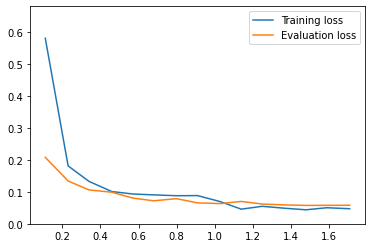

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs['epoch'], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ['loss', 'eval_loss'], ['Training loss', 'Evaluation loss'])

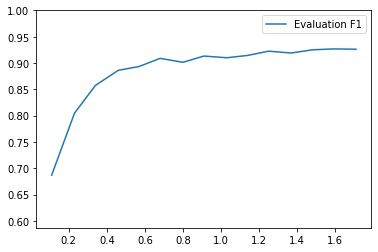

In [30]:
plot(training_logs.logs, ['eval_f1'], ['Evaluation F1'])

---

## Create pipeline



We can wrap our fine-tuned model in a pipeline for convenience. (We need to specify `device` here as the model is on GPU.)

In [31]:
pipe = transformers.pipeline(
    'token-classification',
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy='simple',
    device=0
)

We can then use the pipeline simply as follows:

In [32]:
pipe('Finnish cities include Turku and Tampere.')

[{'entity_group': 'MISC',
  'score': 0.9957795,
  'word': 'Finnish',
  'start': 0,
  'end': 7},
 {'entity_group': 'LOC',
  'score': 0.9922815,
  'word': 'Turku',
  'start': 23,
  'end': 28},
 {'entity_group': 'LOC',
  'score': 0.9891007,
  'word': 'Tampere',
  'start': 33,
  'end': 40}]

Or, for convenience

In [33]:
def tag(text):
    output = pipe(text)
    print('input:', text)
    print('output:', [(o['word'], o['entity_group']) for o in output])

tag('Finnish cities include Turku and Tampere.')

input: Finnish cities include Turku and Tampere.
output: [('Finnish', 'MISC'), ('Turku', 'LOC'), ('Tampere', 'LOC')]


In [34]:
tag('Paavo Nurmi was born in Turku in 1897.')

input: Paavo Nurmi was born in Turku in 1897.
output: [('Paavo Nurmi', 'PER'), ('Turku', 'LOC')]


In [35]:
tag('Nokia is a company founded near the town of Nokia.')

input: Nokia is a company founded near the town of Nokia.
output: [('Nokia', 'ORG'), ('Nokia', 'LOC')]
